# Data cleaning

## Overdose deaths

The Underlying Cause of Death data is offered by the course instructor, and is originally from CDC WONDER- Wide-ranging Online Data for Epidemiologic Research offered by the Center for Disease Control and Prevention. To pull out the overdose death number from the data, we used python to do data cleaning.
The steps are as follows:
<br>
・Read all the 13 files into python as dataframes
<br>
・Delete the rows recording the description of the data source.
<br>
・Delete the rows missing the death number.
<br>
・Filter out the rows which the cause of death is not drug related.
<br>
・Seperate the "County" column into two columns: "State" and "County".
<br>
・Drop columns which we are not going to use in analysis such as "County Code" and "Year Code".
<br>
・Group the rows by "State","County","Year" and sum up the overdose death numbers.
<br>
・Concatenate the 13 dataframes into 1 dataframe
<br>
・Save the dataframe as csv file

In [225]:
#ggplot arguments: http://www.sthda.com/english/wiki/ggplot2-axis-scales-and-transformations#change-x-and-y-axis-limits
#ggplot lm related https://medium.com/r-%E8%AA%9E%E8%A8%80%E8%87%AA%E5%AD%B8%E7%B3%BB%E5%88%97/r%E8%AA%9E%E8%A8%80%E8%87%AA%E5%AD%B8%E6%97%A5%E8%A8%98-9-%E8%BF%B4%E6%AD%B8%E6%A8%A1%E5%9E%8B%E4%BB%8B%E7%B4%B9-a49f81d81eab
#ggplot more than one line in plot https://blog.gtwang.org/r/r-data-exploration-and-visualization/3/

import pandas as pd
import numpy as np
from plotnine import *
import patsy
import statsmodels.formula.api as smf
import warnings; warnings.simplefilter('ignore')

In [226]:
overdose = pd.read_csv("/Users/yu/Documents/Duke/courses/19fall/IDS690.02 python/mid-semester project/estimating-impact-of-opioid-prescription-regulations-team-4/20_intermediate_files/overdose_deaths.csv")
overdose.head()

,State,County,Year,Deaths
0,AK,Anchorage Borough,2003,31.0
1,AK,Matanuska-Susitna Borough,2003,11.0
2,AL,Baldwin County,2003,10.0
3,AL,Jefferson County,2003,69.0
4,AL,Mobile County,2003,26.0


In [227]:
# prepare for the dataset in state level
#create new columns in order to build the linear model for diff-in-diff
overdose_state = overdose.groupby(['State','Year']).sum().reset_index()
overdose_state["Post"] = np.where(overdose_state['Year']<2007,0,1)
overdose_state["P_change"] = np.where(overdose_state['State']=='TX',1,0)
overdose_state["Year_c"] = overdose_state['Year'] - 2007
overdose_state.Year.value_counts()

2014    51
2015    50
2013    50
2012    49
2010    49
2009    49
2007    49
2011    48
2006    48
2008    47
2005    47
2004    46
2003    46
Name: Year, dtype: int64

# Exploratory Data Analysis

First, we take a look at the overall trend of the number of overdose death in U.S.. We can conclude that the number was increasing rapidly from 2003 to 2015.

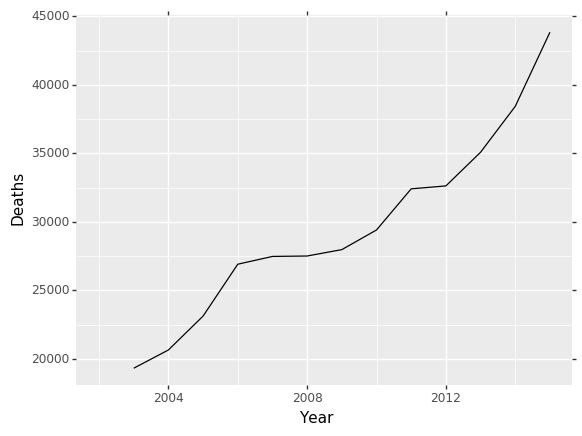

<ggplot: (7551135401)>

In [228]:
# the overall trend of the number of overdose death in U.S.
overdose_US = overdose.groupby(['Year']).sum().reset_index()
(ggplot(aes(x='Year', y='Deaths') , data = overdose_US) + geom_line()  + xlim(2002, 2015))

We can also see the similar trend in TX.
However, there is an obvious decrease around 2007, the year of policy change, which we are interested about.

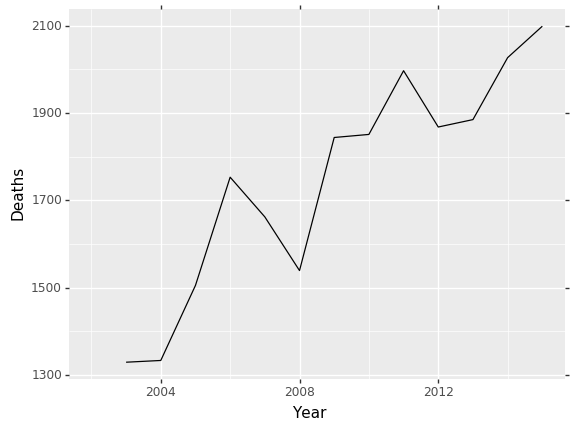

<ggplot: (-9223372029303989195)>

In [229]:
(ggplot(aes(x='Year', y='Deaths') , data = overdose_state.loc[overdose_state['State']=='TX']) + geom_line()  + xlim(2002, 2015))

To further analyze the effect of policy change on the overdose death number in TX, two methods will be applied in this analysis.

# Model & Results

## Pre-Post Model

We pick CA, NM, and AZ as our potential control states for TX.
To determine which state to use as the control state, we use ggplot to see the trend of death numbers from 2004 to 2006, before the year of policy change of TX (2007).
It seems like the trend of CA is most similar to the trend in TX. Therefore, we chose CA as the control state of TX.

In [230]:
#comparing the 3 potential control state for TX
overdose_state_trend = overdose_state.loc[((overdose_state['State']=='TX') | (overdose_state['State']=='CA') | (overdose_state['State']=='NM') | (overdose_state['State']=='AZ')) & ((overdose_state['Year']<2011) & (overdose_state['Year']>2003) )].reset_index(drop = True)

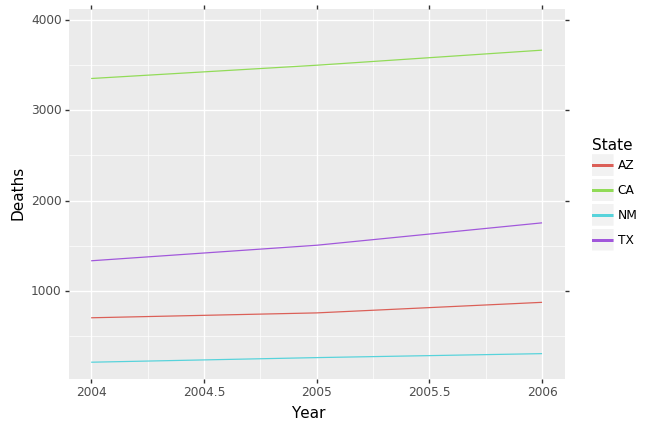

<ggplot: (7551135485)>

In [231]:
#use plot to see the trend of the states
#need to show each year in x axis
(ggplot(aes(x='Year', y='Deaths', group = 'State', color = 'State') , data = overdose_state_trend) + geom_line()  + xlim(2004, 2006))
#geom_smooth(method = 'lm', se = False) 

Next, we use plot to see the trend of overdose death number of TX and CA from 2004 ot 2010 to see whether the trend of TX was different from CA after the policy change in 2007. In 2007, the overdose death number in TX decreased when the overdose death number in CA increased.
Since the policy change was effective on January 4, 2007, we might be able to say that the decrease was because of the policy change.
However, the graph shows that TX and CA had the exactly the same trend after 2007, which indicates that the impact of policy change did not last long.

In [232]:
overdose_state_compare = overdose_state_trend.loc[(overdose_state_trend['State'] == 'TX') | (overdose_state_trend['State'] == 'CA')].reset_index(drop = True)
overdose_state_compare.head()

,State,Year,Deaths,Post,P_change,Year_c
0,CA,2004,3351.0,0,0,-3
1,CA,2005,3498.0,0,0,-2
2,CA,2006,3665.0,0,0,-1
3,CA,2007,3844.0,1,0,0
4,CA,2008,3757.0,1,0,1


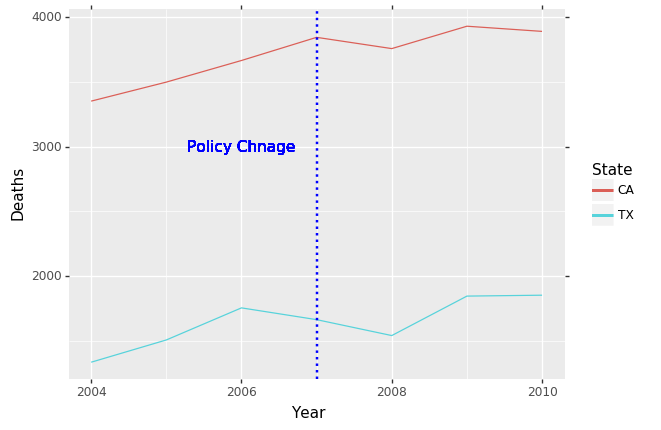

<ggplot: (-9223372029303989167)>

In [233]:
(ggplot(aes(x='Year', y='Deaths', group = 'State', color = 'State') , data = overdose_state_compare) + geom_line()  + xlim(2004, 2010) + geom_vline(xintercept = 2007, linetype="dotted", 
                color = "blue", size=1) + geom_text(x=2006, y=3000, label="Policy Chnage", color = 'blue') )

## Difference-in-difference Model

To apply difference-in-difference analysis to the problem, we create 3 new columns to the dataset.
Post: The year is post policy change or not. If the data of the number of overdose death is after 2007, it would be assigned 1. otherwise, it would be assigned 0.
P_change: Whether the data is in the state with policy change or not. If the data of the number of overdose death is in TX, it would be assigned 1. otherwise, it would be assigned 0.
Year_c: Centered the year. Use the year of policy change- 2007 as 0.
<br>
The linear model for the dataset including the overdose deaths number of TX and CA is as follows:

In [234]:
#apply the linear model to draw the plot like what Nick showed use in pdf
model_dif = smf.ols('Deaths ~ Year_c + Post + P_change + Post*Year_c + Post*P_change + Year_c*P_change + Post*Year_c*P_change', data = overdose_state_compare)
results = model_dif.fit()
results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Deaths   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     303.8
Date:                Tue, 12 Nov 2019   Prob (F-statistic):           3.20e-07
Time:                        17:28:13   Log-Likelihood:                -76.131
No. Observations:                  14   AIC:                             168.3
Df Residuals:                       6   BIC:                             173.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             3818.6667 

According to the model, the overdose death number increased every year during 2004 to 2010. The policy change (P-change) had an impact on decreasing the overdose death number.The overdose death number decreased by 337 people right after policy change. However, if we look at the change in the time trend after the policy change, the overdose death number increased by 129 people.

# Conclusion

According to pre-post model and difference-in-difference model, the policy change in TX had the impact on decreasing the overdose death number. However, the effect only existed in 2007, the year the policy change was applied. After 2008, the trend of overdose death number in TX became the same as the control state- CA, which indicates that the effect of policy change, at least for the new policy in TX, cannot really achieve the goal of decreasing the number of overdose death.